# 신용 카드 거래에 대한 머신 러닝

In [1]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

## 데이터셋 불러오기 및 그래프 생성

In [2]:
import pandas as pd
df = pd.read_csv("./fraudTrain.csv")
df = df[df["is_fraud"]==0].sample(frac=0.20, random_state=42).append(df[df["is_fraud"] == 1])
df

C:\Users\K\AppData\Local\Temp\ipykernel_22044\806809328.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df[df["is_fraud"]==0].sample(frac=0.20, random_state=42).append(df[df["is_fraud"] == 1])


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
811778,811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,...,34.0287,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0
1101718,1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,...,36.7154,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0
800013,800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0
398945,398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,...,48.2777,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0
207455,207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,...,36.4715,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295399,1295399,2020-06-21 01:00:08,3524574586339330,fraud_Kassulke PLC,shopping_net,977.01,Ashley,Cabrera,F,94225 Smith Springs Apt. 617,...,27.6330,-80.4031,105638,"Librarian, public",1986-05-07,a83b093f0c1d9068fa0089f7c722615f,1371776408,26.888686,-80.834389,1
1295491,1295491,2020-06-21 01:53:35,3524574586339330,fraud_Schumm PLC,shopping_net,1210.91,Ashley,Cabrera,F,94225 Smith Springs Apt. 617,...,27.6330,-80.4031,105638,"Librarian, public",1986-05-07,f75b35bed13b9e692f170dba45a15b21,1371779615,28.216707,-79.855648,1
1295532,1295532,2020-06-21 02:16:56,4005676619255478,"fraud_Tillman, Dickinson and Labadie",gas_transport,10.24,William,Perry,M,458 Phillips Island Apt. 768,...,30.4590,-90.9027,71335,Herbalist,1994-05-31,a0ba2472cd3fc9731f2a18d3f308f5c3,1371781016,29.700456,-91.361632,1
1295666,1295666,2020-06-21 03:26:20,3560725013359375,fraud_Corwin-Collins,gas_transport,21.69,Brooke,Smith,F,63542 Luna Brook Apt. 012,...,31.8599,-102.7413,23,Cytogeneticist,1969-09-15,daa281350b1e16093c7b4bf97bf4d6ed,1371785180,32.675272,-103.484949,1


In [3]:
df["is_fraud"].value_counts()

0    257834
1      7506
Name: is_fraud, dtype: int64

In [4]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

In [5]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

In [6]:
G = build_graph_bipartite(df, nx.Graph())

In [7]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G)

True

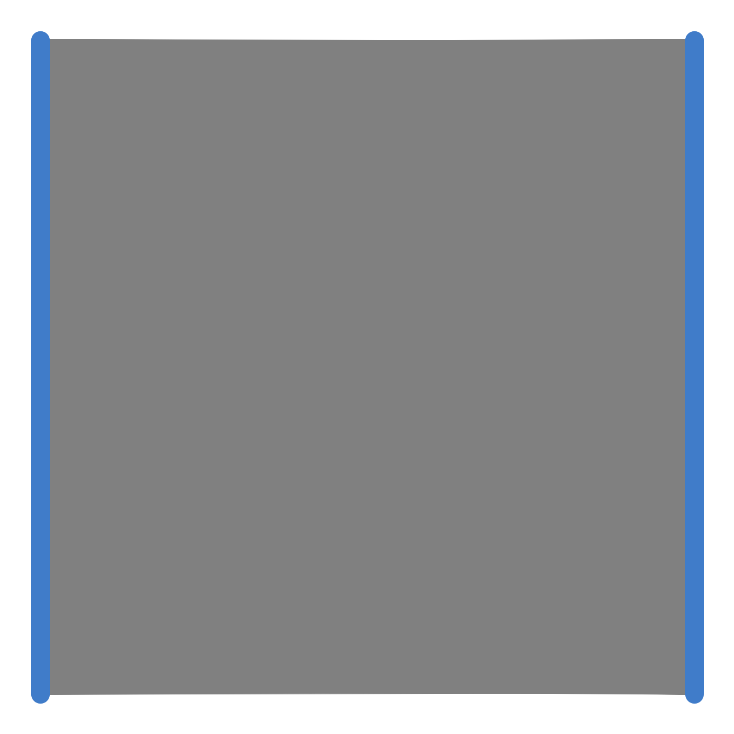

In [8]:
plt.figure(figsize=(10,10))
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
nx.draw(G, pos=pos, with_labels=False, node_color=default_node_color, edge_color=default_edge_color)
plt.show()

## 네트워크 분석

In [9]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1676
Number of edges: 201725
Average degree: 240.7220


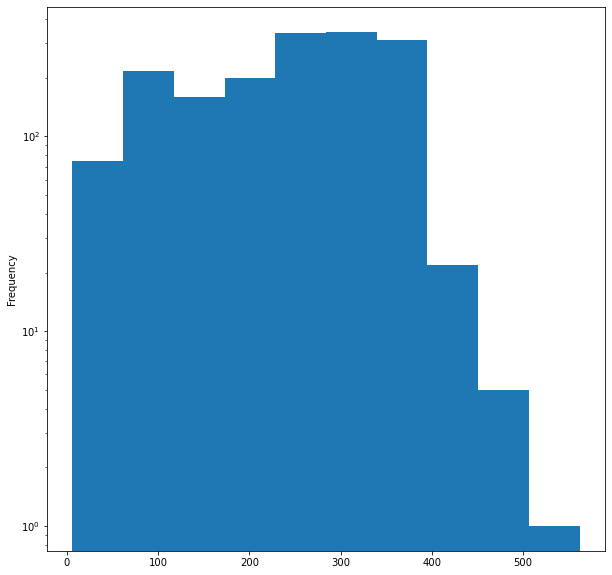

In [10]:
plt.figure(figsize=(10,10))
degrees = pd.Series({k: v for k, v in nx.degree(G)})
degrees.plot.hist()
plt.yscale("log")

In [11]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9,1.0])

array([5.030000e+00, 5.825000e+01, 9.844000e+01, 2.156560e+02,
       1.530595e+04])

In [12]:
quant_dist = np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9])
quant_dist

array([  5.03 ,  58.25 ,  98.44 , 215.656])

In [13]:
allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) 
                                     if d[2]["weight"] < quant_dist[-1]})

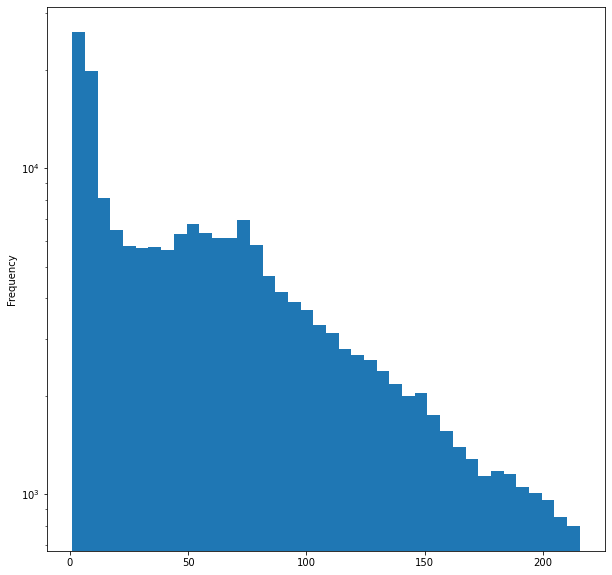

In [14]:
plt.figure(figsize=(10,10))
allEdgesWeightsFiltered.plot.hist(bins=40)
plt.yscale("log")

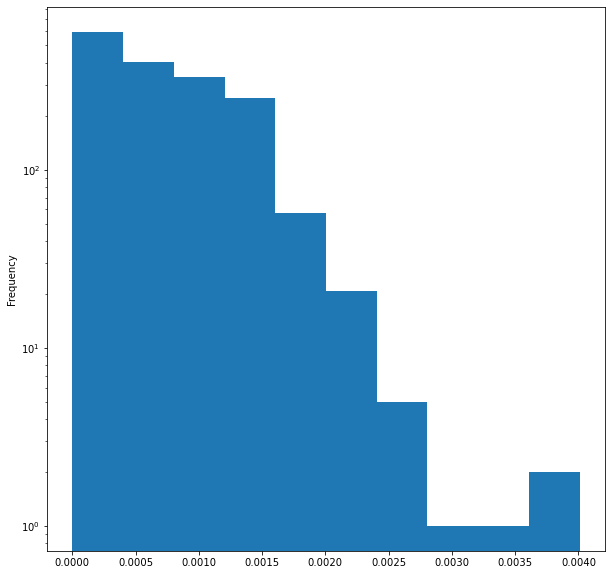

In [15]:
plt.figure(figsize=(10,10))
bC = nx.betweenness_centrality(G)
bc_distr = pd.Series(bC)
bc_distr.plot.hist()
plt.yscale("log")

In [16]:
np.mean(list(bC.values()))

0.000720547185799644

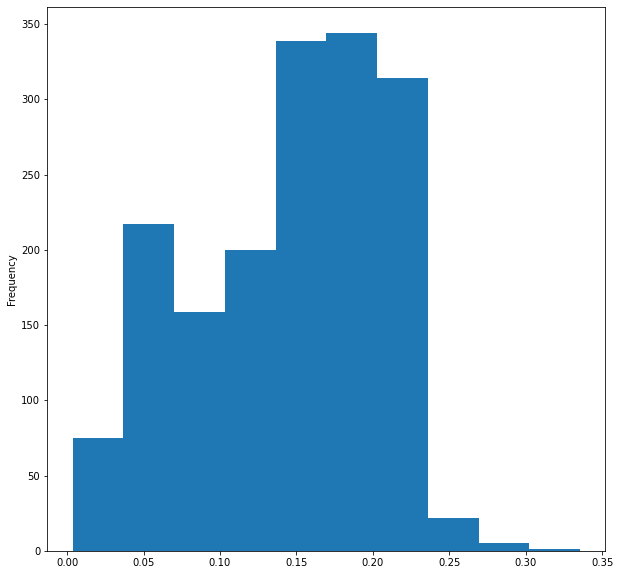

In [17]:
# degree centrality
plt.figure(figsize=(10,10))
deg_C = nx.degree_centrality(G)
degc_distr = pd.Series(deg_C)
degc_distr.plot.hist()

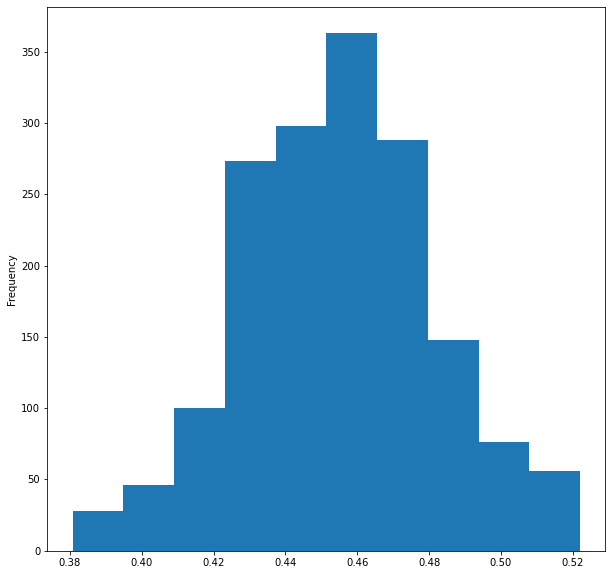

In [18]:
# closeness centrality
plt.figure(figsize=(10,10))
clos_C = nx.closeness_centrality(G)
closc_distr = pd.Series(clos_C)
closc_distr.plot.hist()

In [19]:
np.mean(list(clos_C.values()))

0.45484068767616925

In [20]:
# assortativity
nx.degree_pearson_correlation_coefficient(G)

-0.13774320410493524

### 커뮤니티 감지

In [21]:
import community

parts = community.best_partition(G, random_state=42, weight='weight')

In [22]:
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

3     156
17    140
4     137
16    134
7     131
2     122
8     115
12    107
5      77
6      76
0      71
9      65
10     64
13     61
14     60
11     56
15     53
1      51
dtype: int64

In [23]:
graphs = []
d = {}
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False)

0     15.550239
8     14.736842
16    12.844037
9     12.105263
6     11.940299
4     11.820852
13    11.749347
10    11.428571
14    11.428571
11    10.447761
1      9.854015
15     9.811321
12     8.911917
5      7.106599
3      6.549232
2      4.741980
17     4.644656
7      2.579219
dtype: float64

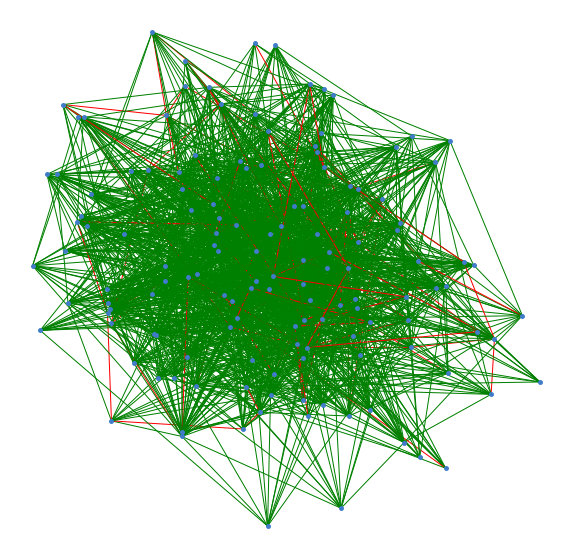

In [24]:
gId = 10
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

## 지도 학습

In [25]:
from sklearn.utils import resample

df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

df_maj_dowsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

1    7506
0    7506
Name: is_fraud, dtype: int64


In [26]:
from sklearn.model_selection import train_test_split


train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))), 
                                                                      list(nx.get_edge_attributes(G_down, "label").values()), 
                                                                      test_size=0.20, 
                                                                      random_state=42)

In [27]:
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

In [28]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.03s/it]


In [29]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv) 

    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    rf.fit(train_embeddings, train_labels); 

    y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.7578125
Recall: 0.5169886742171885
F1-Score: 0.6146534653465346
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.7262330235882773
Recall: 0.6768820786142572
F1-Score: 0.7006896551724138
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.627431906614786
Recall: 0.8594270486342438
F1-Score: 0.7253303345515884
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.6301369863013698
Recall: 0.8580946035976016
F1-Score: 0.7266572637517631


## 비지도 학습

In [30]:
nod2vec_unsup = Node2Vec(G_down, weight_key='weight')
unsup_vals = nod2vec_unsup.fit(window=10)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.07s/it]


In [31]:
from sklearn.cluster import KMeans

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
true_labels = [x for x in nx.get_edge_attributes(G_down, "label").values()]

for cl in classes:
    embedding_edge = cl(keyed_vectors=unsup_vals.wv) 

    embedding = [embedding_edge[str(x[0]), str(x[1])] for x in G_down.edges()]
    kmeans = KMeans(2, random_state=42).fit(embedding)
    
    
    nmi = metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_)
    ho = metrics.homogeneity_score(true_labels, kmeans.labels_)
    co = metrics.completeness_score(true_labels, kmeans.labels_)
    vmeasure = metrics.v_measure_score(true_labels, kmeans.labels_)
    
    print(cl)
    print('NMI:', nmi)
    print('Homogeneity:', ho)
    print('Completeness:', co)
    print('V-Measure:', vmeasure)

<class 'node2vec.edges.HadamardEmbedder'>
NMI: 0.3511309426026109
Homogeneity: 0.339480937405489
Completeness: 0.36368000793628025
V-Measure: 0.35116407083682827
<class 'node2vec.edges.AverageEmbedder'>
NMI: 0.07706596518157295
Homogeneity: 0.07618099276430099
Completeness: 0.0780661972253154
V-Measure: 0.07711207453903823
<class 'node2vec.edges.WeightedL1Embedder'>
NMI: 0.0610710779335852
Homogeneity: 0.061116702243028204
Completeness: 0.06111813842013404
V-Measure: 0.061117420323144066
<class 'node2vec.edges.WeightedL2Embedder'>
NMI: 0.05021326471658577
Homogeneity: 0.049711921954089015
Completeness: 0.0508216478321283
V-Measure: 0.050260660115449766


### 삼분 그래프 네트워크 분석

In [32]:
G = build_graph_tripartite(df, nx.Graph())

In [33]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 267016
Number of edges: 530680
Average degree:   3.9749


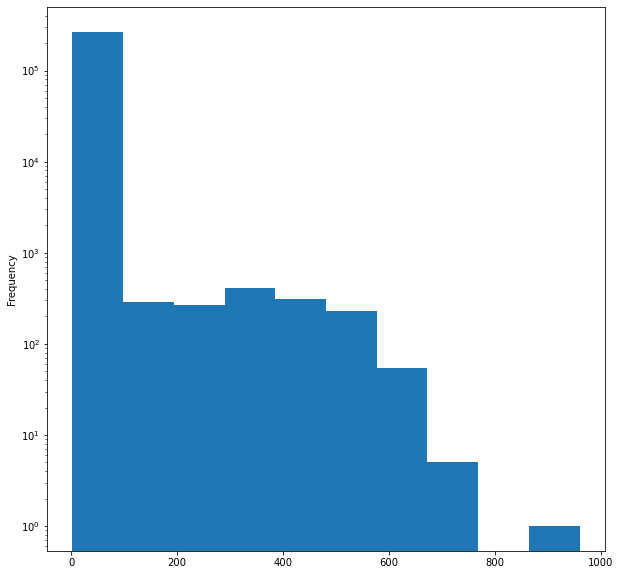

In [34]:
plt.figure(figsize=(10,10))
degrees = pd.Series({k: v for k, v in nx.degree(G)})
degrees.plot.hist()
plt.yscale("log")

In [35]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9,1.0])

array([4.210000e+00, 4.851000e+01, 7.640000e+01, 1.471000e+02,
       1.530595e+04])

In [36]:
quant_dist = np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9])
quant_dist

array([  4.21,  48.51,  76.4 , 147.1 ])

In [37]:
allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) 
                                     if d[2]["weight"] < quant_dist[-1]})

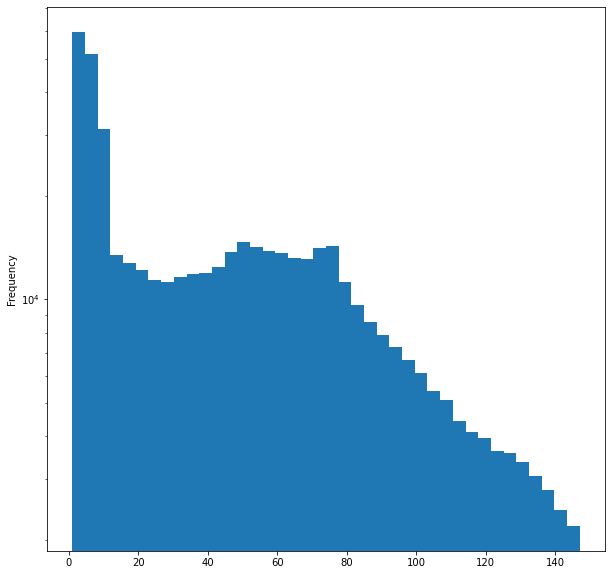

In [38]:
plt.figure(figsize=(10,10))
allEdgesWeightsFiltered.plot.hist(bins=40)
plt.yscale("log")

In [40]:
from multiprocessing import Pool
import time
import itertools

def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), G.order() // node_divisor))
    num_chunks = len(node_chunks)
    bt_sc = p.starmap(
        nx.betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            [None] * num_chunks,
        ),
    )

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c


In [ ]:
plt.figure(figsize=(10,10))
bC = betweenness_centrality_parallel(G, 4)
bc_distr = pd.Series(bC)
bc_distr.plot.hist()
plt.yscale("log")